<a href="https://colab.research.google.com/github/jindalk/pytorch_projects/blob/main/02_pbmc_3k_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting adaptive vs immune cell types from scRNA-seq data - Human PBMCs

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gex = pd.read_csv('/content/drive/MyDrive/single_cell/data/pbmc_3k_proc.csv', index_col=0)
meta = pd.read_csv('/content/drive/MyDrive/single_cell/data/pbmc_3k_proc_meta.csv', index_col=0)

In [ ]:
gex.shape

(2638, 1838)

In [ ]:
gex = gex.astype(np.float32)

In [ ]:
assert((gex.index == meta.index).all())

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(1838, 50)
    self.fc2 = nn.Linear(50,10)
    self.fc3 = nn.Linear(10,1)

  def forward(self, input):
    f1 = F.relu(self.fc1(input))
    f2 = F.relu(self.fc2(f1))
    f3 = F.sigmoid(self.fc3(f2))
    return f3

In [ ]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=1838, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

6
torch.Size([50, 1838])


In [ ]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [ ]:
meta['immune'].value_counts()

,count
immune,
adaptive,1802
innate,836


In [ ]:
labels = meta['immune'].apply(lambda x: 0. if x=='adaptive' else 1.).values
labels = torch.from_numpy(labels)
labels = labels.type(torch.float32)

In [ ]:
data = torch.from_numpy(gex.values)

In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2,
                                                                    random_state = 42, stratify = labels)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.1,
                                                                    random_state = 42, stratify = train_labels)

In [ ]:
len(train_labels), len(val_labels), len(test_labels)

(1899, 211, 528)

In [ ]:
train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

In [ ]:
epochs = 100

In [ ]:
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
  print_bool = True if epoch%30==0 else False
  net.train()
  for train_data_curr, train_label_curr in train_loader:
    optimizer.zero_grad()

    #fwd
    pred = net(train_data_curr).squeeze()

    #loss
    train_loss = loss_fn(pred, train_label_curr)
    train_loss_list.append(train_loss.item())

    #bwd
    train_loss.backward()

    #update weight
    optimizer.step()

    #validation loop
    net.eval()
    val_loss = 0
    with torch.no_grad():
      for val_data_curr, val_label_curr in val_loader:
        val_pred = net(val_data_curr).squeeze()
        val_loss += loss_fn(val_pred, val_label_curr).item()
    if(print_bool):
      print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader):.4f}")
    val_loss_list.append(val_loss / len(val_loader))


#test
net.eval()
test_loss = 0
with torch.no_grad():
  for test_data_curr, test_label_curr in test_loader:
    test_pred = net(test_data_curr).squeeze()
    test_loss += loss_fn(test_pred, test_label_curr).item()
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0957
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.2187
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0924
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0999
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0927
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, Validation Loss: 0.0925
Epoch 1, V

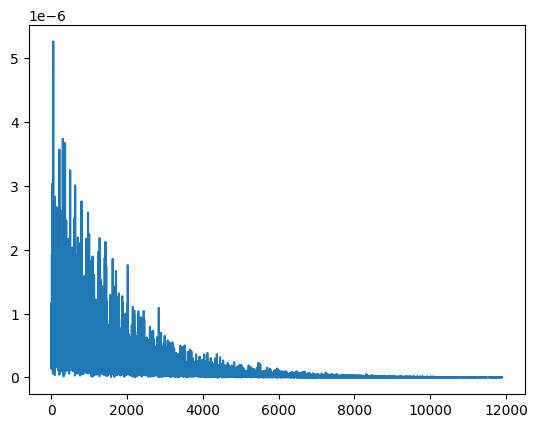

In [ ]:
plt.plot(np.array(train_loss_list))

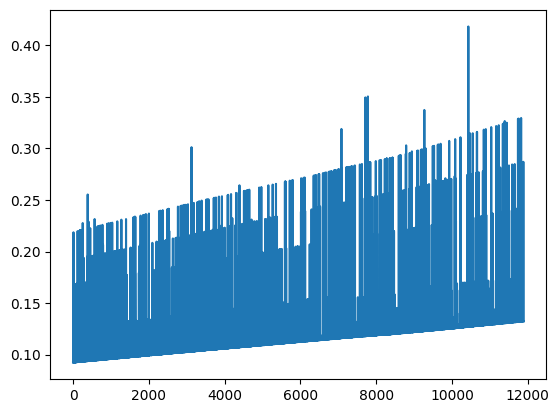

In [ ]:
plt.plot(np.array(val_loss_list))

In [ ]:
#model is overfitting

In [ ]:
#lets try a new optimizer with weight decay

In [ ]:
optimizer_decay = optim.Adam(net.parameters(), weight_decay=1e-4)

In [ ]:
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
  print_bool = True if epoch%40==0 else False
  net.train()
  for train_data_curr, train_label_curr in train_loader:
    optimizer_decay.zero_grad()

    #fwd
    pred = net(train_data_curr).squeeze()

    #loss
    train_loss = loss_fn(pred, train_label_curr)
    train_loss_list.append(train_loss.item())

    #bwd
    train_loss.backward()

    #update weight
    optimizer_decay.step()

    #validation loop
    net.eval()
    val_loss = 0
    with torch.no_grad():
      for val_data_curr, val_label_curr in val_loader:
        val_pred = net(val_data_curr).squeeze()
        val_loss += loss_fn(val_pred, val_label_curr).item()
    if(print_bool):
      print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader):.4f}")
    val_loss_list.append(val_loss / len(val_loader))


#test
net.eval()
test_loss = 0
with torch.no_grad():
  for test_data_curr, test_label_curr in test_loader:
    test_pred = net(test_data_curr).squeeze()
    test_loss += loss_fn(test_pred, test_label_curr).item()
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Epoch 1, Validation Loss: 0.1296
Epoch 1, Validation Loss: 0.1268
Epoch 1, Validation Loss: 0.1242
Epoch 1, Validation Loss: 0.1218
Epoch 1, Validation Loss: 0.1198
Epoch 1, Validation Loss: 0.1174
Epoch 1, Validation Loss: 0.1155
Epoch 1, Validation Loss: 0.1131
Epoch 1, Validation Loss: 0.1111
Epoch 1, Validation Loss: 0.1090
Epoch 1, Validation Loss: 0.1068
Epoch 1, Validation Loss: 0.1044
Epoch 1, Validation Loss: 0.1024
Epoch 1, Validation Loss: 0.1008
Epoch 1, Validation Loss: 0.1153
Epoch 1, Validation Loss: 0.1291
Epoch 1, Validation Loss: 0.0946
Epoch 1, Validation Loss: 0.0906
Epoch 1, Validation Loss: 0.0870
Epoch 1, Validation Loss: 0.0835
Epoch 1, Validation Loss: 0.0804
Epoch 1, Validation Loss: 0.1464
Epoch 1, Validation Loss: 0.0744
Epoch 1, Validation Loss: 0.0725
Epoch 1, Validation Loss: 0.1146
Epoch 1, Validation Loss: 0.0717
Epoch 1, Validation Loss: 0.0720
Epoch 1, Validation Loss: 0.0718
Epoch 1, Validation Loss: 0.0827
Epoch 1, Validation Loss: 0.0794
Epoch 1, V

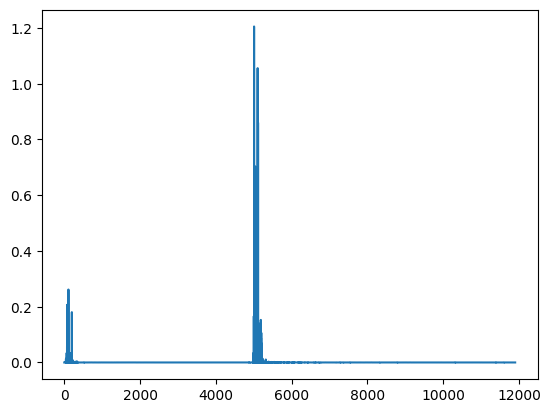

In [ ]:
plt.plot(np.array(train_loss_list))

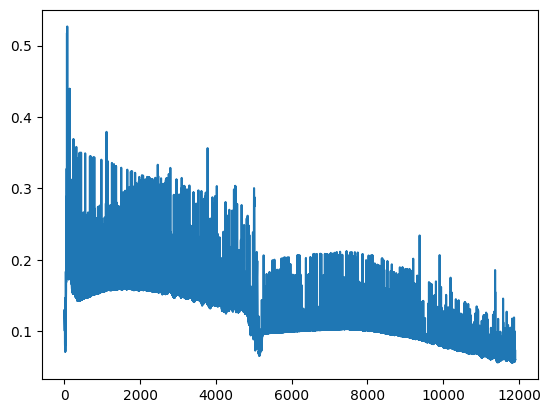

In [ ]:
plt.plot(np.array(val_loss_list))

In [ ]:
#plots look way better, and test loss is much lower. Can we improve it further with dropout?

In [ ]:
class Net_dropout(Net):
  def __init__(self, drop_rate=0.4):
    super(Net_dropout, self).__init__()
    self.dropout1 = nn.Dropout(drop_rate)
    self.dropout2 = nn.Dropout(drop_rate)

  def forward(self, input):
    f1 = F.relu(self.fc1(input))
    f1_drop = self.dropout1(f1)

    f2 = F.relu(self.fc2(f1_drop))
    f2_drop = self.dropout2(f2)

    f3 = F.sigmoid(self.fc3(f2_drop))
    return f3

In [ ]:
net2 = Net_dropout()
optimizer_decay_drop = optim.Adam(net2.parameters(), weight_decay=1e-4)

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
  print_bool = True if epoch%40==0 else False
  net2.train()
  for train_data_curr, train_label_curr in train_loader:
    optimizer_decay_drop.zero_grad()

    #fwd
    pred = net2(train_data_curr).squeeze()

    #loss
    train_loss = loss_fn(pred, train_label_curr)
    train_loss_list.append(train_loss.item())

    #bwd
    train_loss.backward()

    #update weight
    optimizer_decay_drop.step()

    #validation loop
    net2.eval()
    val_loss = 0
    with torch.no_grad():
      for val_data_curr, val_label_curr in val_loader:
        val_pred = net2(val_data_curr).squeeze()
        val_loss += loss_fn(val_pred, val_label_curr).item()
    val_loss_list.append(val_loss / len(val_loader))


#test
net2.eval()
test_loss = 0
with torch.no_grad():
  for test_data_curr, test_label_curr in test_loader:
    test_pred = net2(test_data_curr).squeeze()
    test_loss += loss_fn(test_pred, test_label_curr).item()
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.1499


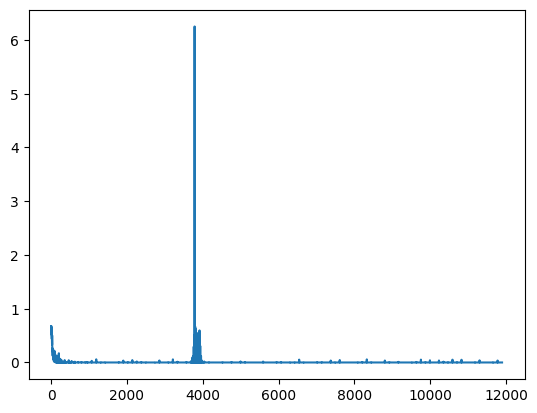

In [ ]:
plt.plot(np.array(train_loss_list))

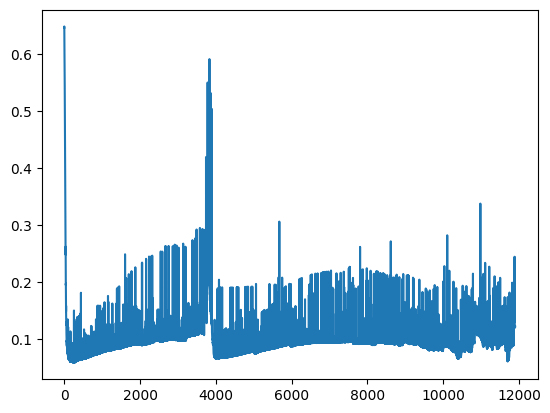

In [ ]:
plt.plot(np.array(val_loss_list))

In [ ]:
#not the best

In [ ]:
net2 = Net_dropout(drop_rate=0.1)
optimizer_decay_drop = optim.Adam(net2.parameters(), weight_decay=1e-4)

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
  print_bool = True if epoch%40==0 else False
  net2.train()
  for train_data_curr, train_label_curr in train_loader:
    optimizer_decay_drop.zero_grad()

    #fwd
    pred = net2(train_data_curr).squeeze()

    #loss
    train_loss = loss_fn(pred, train_label_curr)
    train_loss_list.append(train_loss.item())

    #bwd
    train_loss.backward()

    #update weight
    optimizer_decay_drop.step()

    #validation loop
    net2.eval()
    val_loss = 0
    with torch.no_grad():
      for val_data_curr, val_label_curr in val_loader:
        val_pred = net2(val_data_curr).squeeze()
        val_loss += loss_fn(val_pred, val_label_curr).item()
    val_loss_list.append(val_loss / len(val_loader))


#test
net2.eval()
test_loss = 0
with torch.no_grad():
  for test_data_curr, test_label_curr in test_loader:
    test_pred = net2(test_data_curr).squeeze()
    test_loss += loss_fn(test_pred, test_label_curr).item()
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.1042


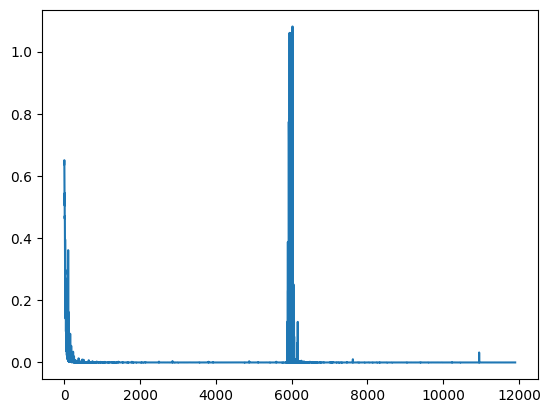

In [ ]:
plt.plot(np.array(train_loss_list))

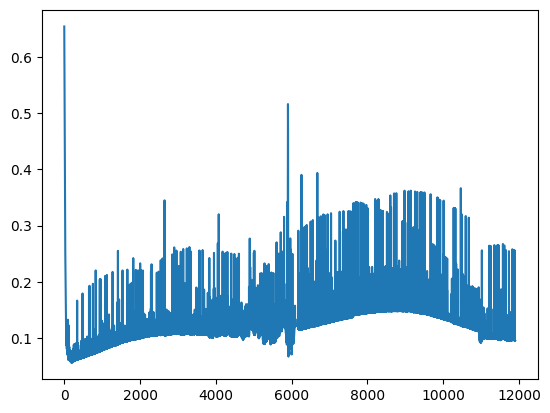

In [ ]:
plt.plot(np.array(val_loss_list))

In [ ]:
#still bad, avoid dropout and lets try lower learning rate

In [ ]:
optimizer_decay_drop_slowlearn = optim.Adam(net.parameters(), weight_decay=1e-4, lr=0.0001)

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
  print_bool = True if epoch%40==0 else False
  net.train()
  for train_data_curr, train_label_curr in train_loader:
    optimizer_decay_drop_slowlearn.zero_grad()

    #fwd
    pred = net(train_data_curr).squeeze()

    #loss
    train_loss = loss_fn(pred, train_label_curr)
    train_loss_list.append(train_loss.item())

    #bwd
    train_loss.backward()

    #update weight
    optimizer_decay_drop_slowlearn.step()

    #validation loop
    net.eval()
    val_loss = 0
    with torch.no_grad():
      for val_data_curr, val_label_curr in val_loader:
        val_pred = net(val_data_curr).squeeze()
        val_loss += loss_fn(val_pred, val_label_curr).item()
    val_loss_list.append(val_loss / len(val_loader))


#test
net.eval()
test_loss = 0
with torch.no_grad():
  for test_data_curr, test_label_curr in test_loader:
    test_pred = net(test_data_curr).squeeze()
    test_loss += loss_fn(test_pred, test_label_curr).item()
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.0644


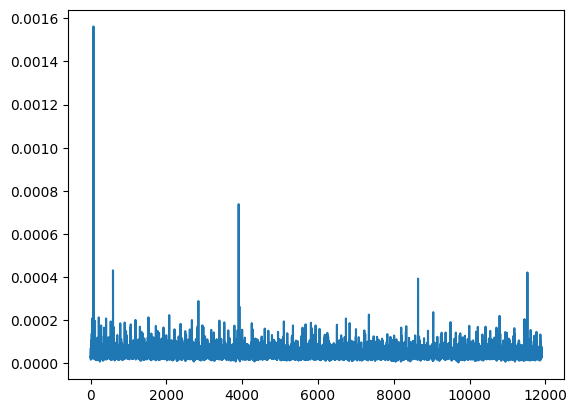

In [ ]:
plt.plot(np.array(train_loss_list))

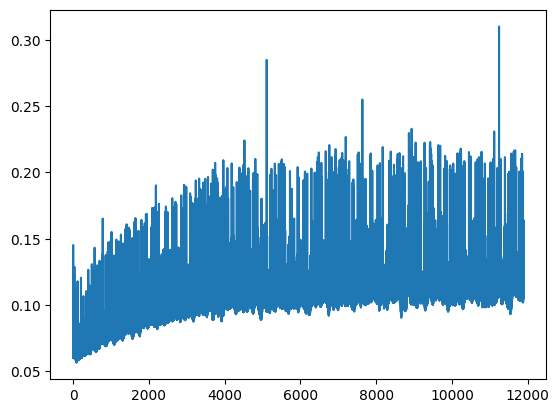

In [ ]:
plt.plot(np.array(val_loss_list))

In [ ]:
epochs = 500
optimizer_decay = optim.Adam(net.parameters(), weight_decay=1e-4)

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
  print_bool = True if epoch%40==0 else False
  net.train()
  for train_data_curr, train_label_curr in train_loader:
    optimizer_decay.zero_grad()

    #fwd
    pred = net(train_data_curr).squeeze()

    #loss
    train_loss = loss_fn(pred, train_label_curr)
    train_loss_list.append(train_loss.item())

    #bwd
    train_loss.backward()

    #update weight
    optimizer_decay.step()

    #validation loop
    net.eval()
    val_loss = 0
    with torch.no_grad():
      for val_data_curr, val_label_curr in val_loader:
        val_pred = net(val_data_curr).squeeze()
        val_loss += loss_fn(val_pred, val_label_curr).item()
    val_loss_list.append(val_loss / len(val_loader))


#test
net.eval()
test_loss = 0
with torch.no_grad():
  for test_data_curr, test_label_curr in test_loader:
    test_pred = net(test_data_curr).squeeze()
    test_loss += loss_fn(test_pred, test_label_curr).item()
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.1206


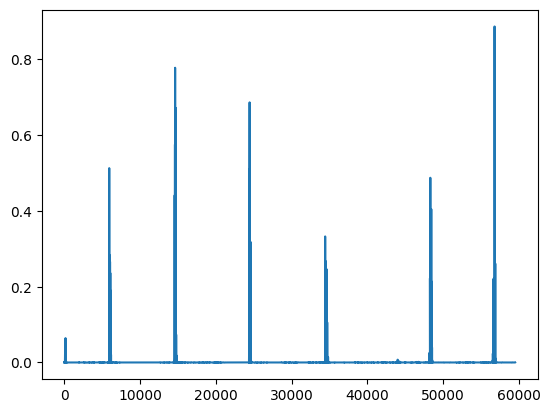

In [ ]:
plt.plot(np.array(train_loss_list))

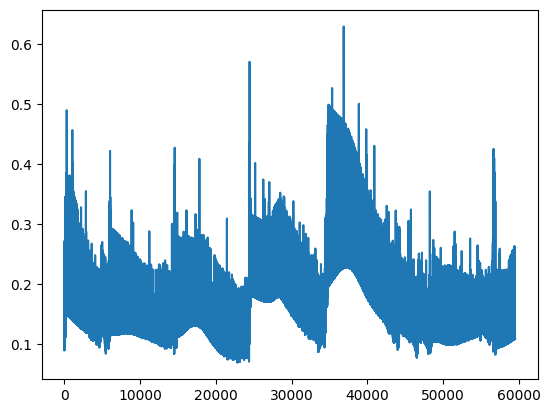

In [ ]:
plt.plot(np.array(val_loss_list))

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(1838, 50)
    self.bn1 = nn.BatchNorm1d(50)
    self.fc2 = nn.Linear(50,10)
    self.bn2 = nn.BatchNorm1d(10)
    self.fc3 = nn.Linear(10,1)

  def forward(self, input):
    f1 = self.fc1(input)
    f1 = F.relu(self.bn1(f1))

    f2 = self.fc2(f1)
    f2 = F.relu(self.bn2(f2))

    f3 = F.sigmoid(self.fc3(f2))
    return f3

net = Net()

In [ ]:
epochs = 100
optimizer_decay = optim.Adam(net.parameters(), weight_decay=1e-3)

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
  print_bool = True if epoch%40==0 else False
  net.train()
  for train_data_curr, train_label_curr in train_loader:
    optimizer_decay.zero_grad()

    #fwd
    pred = net(train_data_curr).squeeze()

    #loss
    train_loss = loss_fn(pred, train_label_curr)
    train_loss_list.append(train_loss.item())

    #bwd
    train_loss.backward()
    utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

    #update weight
    optimizer_decay.step()

    #validation loop
    net.eval()
    val_loss = 0
    with torch.no_grad():
      for val_data_curr, val_label_curr in val_loader:
        val_pred = net(val_data_curr).squeeze()
        val_loss += loss_fn(val_pred, val_label_curr).item()
    val_loss_list.append(val_loss / len(val_loader))


#test
net.eval()
test_loss = 0
with torch.no_grad():
  for test_data_curr, test_label_curr in test_loader:
    test_pred = net(test_data_curr).squeeze()
    test_loss += loss_fn(test_pred, test_label_curr).item()
print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Test Loss: 0.0588


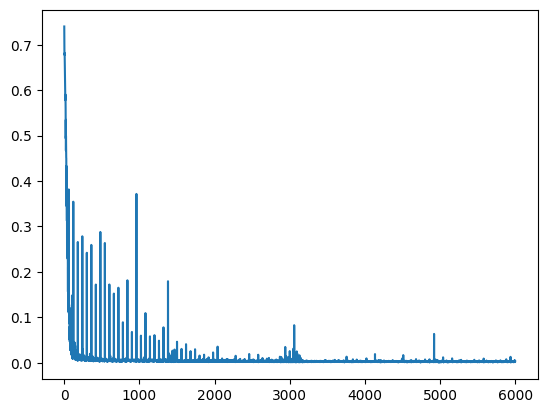

In [ ]:
plt.plot(np.array(train_loss_list))

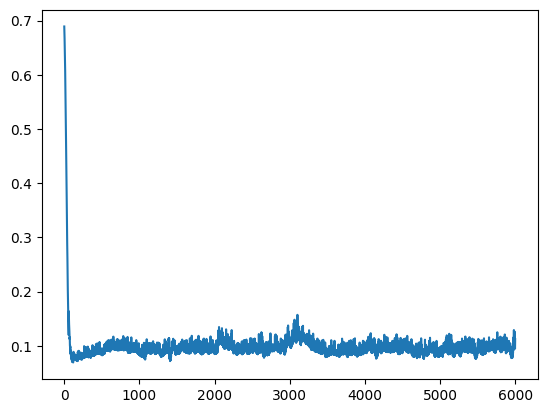

In [ ]:
plt.plot(np.array(val_loss_list))

In [ ]:
 #save final model
 torch.save(net.state_dict(), '/content/drive/MyDrive/single_cell/data/pbmc_3k_model.pth')